In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.6 MB/s eta 0:00:00


In [ ]:
pip install -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
from google.colab import userdata
GEMENI_API_KEY = userdata.get('GOOGLE_GEMENI_API_KEY')

#### LLM

In [ ]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = GEMENI_API_KEY

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [ ]:
!pip install langchain-huggingface

#### Embedding Model

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

# Initialize your embedding model
embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Load saved vector store

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 18.4 MB/s eta 0:00:00


In [ ]:
from langchain_community.vectorstores import FAISS

In [ ]:
vector_store = FAISS.load_local(
    folder_path="/content/drive/My Drive/10Academy/Week6/Data/faiss_with_metadata/",
    embeddings=embedding_function,
    allow_dangerous_deserialization=True
)

In [ ]:
LANGSMITH_API_KEY = userdata.get('LANGSMITH_API_KEY_ACCESS_TOKEN')

#### Pulling prompt from langchain hum

In [ ]:
from langsmith import Client
client = Client(api_key=LANGSMITH_API_KEY)
prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

In [ ]:
# import bs4
# from langchain import hub
# from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
# from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=5)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

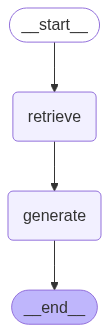

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Question1

In [ ]:
result = graph.invoke({"question": "What is the main complaints customers have?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='d8380f37-e591-4442-a8e9-2004899497a2', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 281847, 'Complaint ID': '3336248', 'Product': 'Credit card or prepaid card'}, page_content='are a lot of complaints of them doing this to customers.'), Document(id='f14ae90e-d7bd-4a93-8b26-9f4c1448ed6f', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 14072, 'Complaint ID': '11801814', 'Product': 'Checking or savings account'}, page_content='information and when you complain about it they have no explanation. Its obvious they dont care about their customers.'), Document(id='6e55b653-b86b-48aa-8346-c0739a0b16d5', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 181546, 'Complaint ID': '3227643', 'Product': 'Checking or savings account'}, page_content='There were many more anti-customer things said but here is a summary of my comp

#### Question2

In [ ]:
result = graph.invoke({"question": "Which product has the most complaints?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='5799ace1-350b-458f-bb82-d7bd84aaa03a', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 228101, 'Complaint ID': '2726026', 'Product': 'Checking or savings account'}, page_content='What product or service is your complaint about?'), Document(id='656d6335-afbb-48c9-88ec-b8d6ad2e6336', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 79966, 'Complaint ID': '8350532', 'Product': 'Credit card'}, page_content="single complaint. Over the most recent two years I've made some sales -- again absent of complaints -- but also some purchases."), Document(id='015e0fae-db1b-4751-88d2-8276112df097', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 135054, 'Complaint ID': '4457879', 'Product': 'Credit card or prepaid card'}, page_content='I tried the XXXX what an oxymoron. They give XXXX a top rating. I will never trust them again. 

#### Question3

In [ ]:
result = graph.invoke({"question": "How many customers faced issues with BNPL products?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='803ec5d8-d746-4041-8fea-ebe08c8e0767', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 67202, 'Complaint ID': '5756204', 'Product': 'Credit card or prepaid card'}, page_content='Many customers are experiencing similar issues.'), Document(id='fa6a0dea-9255-412a-b5fb-fb9a036afa60', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 68754, 'Complaint ID': '12214267', 'Product': 'Payday loan, title loan, personal loan, or advance loan'}, page_content="Many consumer advocacy groups and financial experts have raised concerns about the inconsistent reporting practices of BNPL companies. Reporting only negative data creates an incomplete and potentially damaging picture of a consumer 's creditworthiness. \n\nIt is my understanding that the CFPB has been looking into the BNPL sector, and the unfair practices that are being used."), Document(id='5893197b-acda-4386-abff-2dfb02

#### Question4

In [ ]:
result = graph.invoke({"question": "What are the main issues faced with customers regarding BNPL products?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='803ec5d8-d746-4041-8fea-ebe08c8e0767', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 67202, 'Complaint ID': '5756204', 'Product': 'Credit card or prepaid card'}, page_content='Many customers are experiencing similar issues.'), Document(id='1d7ffa83-ad53-4382-8abe-aabc5203c983', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 86688, 'Complaint ID': '8136959', 'Product': 'Checking or savings account'}, page_content='down of issues and stress and XXXX  for its consumers where nothing is done and loyal people like myself who have been with the company and also have relations with other banking institutions with no issues and dont see the same problem exist, go unheard or hear the excuses the customer service representatives have to apply as a cover where the underlying issues continue to get overlooked and continue to cause ongoing problems and stress for the consu

Question5

In [ ]:
result = graph.invoke({"question": "what are some minoritiy but critical comments?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='c7c3c080-9653-4a65-9dc2-ee9e2e917dbc', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 203130, 'Complaint ID': '11504271', 'Product': 'Checking or savings account'}, page_content='are unacceptable and demand immediate attention and resolution.'), Document(id='a1ba1b85-94d8-4be6-9b0d-ca938a8a5164', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 131971, 'Complaint ID': '6611960', 'Product': 'Credit card or prepaid card'}, page_content='Consumer complaint narrative: XXXX XXXX XXXX XXXX XXXX have conspired against consumer by adding negative remarks. This is a response just for you two'), Document(id='142c81a3-51c9-4549-85ed-093dffdb6764', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 282844, 'Complaint ID': '3864806', 'Product': 'Credit card or prepaid card'}, page_content='ABOUT HIS STAFF. XXXX told me that he d

In [ ]:
result = graph.invoke({"question": "what are some minoritiy but critical complaints?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='fb9b0d52-1b98-4a70-a29f-39e334d4e1ef', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 30144, 'Complaint ID': '11434670', 'Product': 'Credit card'}, page_content='complaints. They never even mention it in there resolution letters citing no fault on there part in vague descriptions never actually addressing the real problem.'), Document(id='91a94f3c-0b9b-4247-9c23-cf2a44889982', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 351288, 'Complaint ID': '3076396', 'Product': 'Checking or savings account'}, page_content='I will be submitting documents to substantiate the complaints.'), Document(id='0211c7be-0caf-4a3c-9c7f-ce3cc34bc5e3', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 339482, 'Complaint ID': '9137103', 'Product': 'Credit card'}, page_content='complaint in hopes that something can be done.'), Document(id

Question6

In [ ]:
result = graph.invoke({"question": "Which product has the list complaints?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='5799ace1-350b-458f-bb82-d7bd84aaa03a', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 228101, 'Complaint ID': '2726026', 'Product': 'Checking or savings account'}, page_content='What product or service is your complaint about?'), Document(id='1a74e8c4-c82b-41fd-a492-6c66d46c72a0', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 324075, 'Complaint ID': '9726936', 'Product': 'Checking or savings account'}, page_content="Consumer complaint narrative: I have tried my best to fit my multiple problems into one listed category but it isn't really very exact."), Document(id='eca091a1-692e-4507-9b6a-09df5c0461b1', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 290232, 'Complaint ID': '10159208', 'Product': 'Credit card'}, page_content='XXXX Click here for a list of the complaints associated with each category.'), Docume

In [ ]:
result = graph.invoke({"question": "What are peoples complaints about the Checking or savings account product, please also provide metadata?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='cd5314e9-282d-4efa-a2b6-2e09c29ae76e', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 111550, 'Complaint ID': '7808761', 'Product': 'Checking or savings account'}, page_content='this complaint again only for the accounts I am an account holder on ( house, groceries, billpay, savings ).'), Document(id='12697670-f252-4519-bd78-7135e2c681fc', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 61015, 'Complaint ID': '9912531', 'Product': 'Checking or savings account'}, page_content='Consumer complaint narrative: I opened my checking and saving account with Bank of America around 4 or 5 years ago. I have been using the both account in the similar matters for years without any issue.'), Document(id='fc5d37d7-82b6-48f9-baff-25a7d8830dd9', metadata={'source': '/content/drive/My Drive/10Academy/Week6/Data/final_filtered_data.csv', 'row': 178073, 'Complaint ID': '3282768', '